# UHI analysis 2015

We'll try to figure out whether there is a systematic relationship between elevated urban air temperatures and population density based on an archive of weather station data from [NOAA's GHCN](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-ghcn) and population data from the [GHSL](https://ghsl.jrc.ec.europa.eu/). 

After [preparing the weather station data](1_NOAA_weather_stations_preparation.ipynb), we'll join the stations to the 2015 data and run a multivariate regression to see how big an impact the population density has.


# ⚠ 

Some parts of this analysis take quite a while. Look for the fields mared with a 

# 🏁

these indicate where intermediate results have been stored and can simply be re-used instead of running the analysis again.

Import some libraries we'll use:


In [1]:
import urllib.request
import gzip
import zipfile
import pandas as pd
import os
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Proj, transform
from scipy.spatial import cKDTree  
from scipy import stats
import urllib.request

from sklearn import linear_model

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 10.0) # larger plots

### Load prepared NOAA weather stations

In [2]:
file = 'stations_complete.csv'

if os.path.isfile(file):
    stations = pd.read_csv(file, index_col=0)
else:
    print("File stations_complete.csv not found. Run the notebook 1_NOAA_weather_stations_preparation first.")

stations.head(5)

,station,lat,lon,elevation,name,country,mollX,mollY,pop2015,pop2000,...,NN_popdens1975_diff,nn_elev_diff,nn_popdens2015_diff,nn_popdens2000_diff,nn_popdens1990_diff,nn_popdens1975_diff,nn_lat_diff,climatezone,geometry,Region_Name
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.0,0.0,...,0.0,-9.1,0.0,0.0,0.0,0.0,-0.0166,2,POINT (-61.7833 17.1167),Latin America
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.0,0.0,...,0.0,9.1,0.0,0.0,0.0,0.0,0.0166,2,POINT (-61.7833 17.1333),Latin America
245,AR000000001,-29.6000,-58.1500,109.0,BAIBENE,AR,-5.344510e+06,-3.596996e+06,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,-0.2300,9,POINT (-58.15 -29.6),Latin America
246,AR000000002,-29.8200,-57.4200,75.0,BONPLAND,AR,-5.270234e+06,-3.622776e+06,0.0,0.0,...,0.0,4.9,0.0,0.0,0.0,0.0,-0.1310,9,POINT (-57.42 -29.82),Latin America
247,AR000000003,-29.9800,-58.2800,90.0,CAZADORES CORRENTINOS,AR,-5.343830e+06,-3.641512e+06,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0500,9,POINT (-58.28 -29.98),Latin America


### Get the NOAA NCDC data

Download the data from NOAA. The columns in the file are documented [here](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/readme.txt).

In [3]:
file = '2015.csv.gz'
if os.path.isfile(file):
    print(file, 'already downloaded.')
else:
    urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2015.csv.gz', file)

2015.csv.gz already downloaded.


Before we can read the file, we'll define our own date parser:

In [4]:
noaadateparser = lambda x: pd.datetime.strptime(x, "%Y%m%d")


Unzip the file and load the CSV with pandas, using our date parser. We'll also give the columns names since the CSV doesn't have a header 🧟‍. This takes a few minutes:

In [5]:
with gzip.open('2015.csv.gz') as f:

    data_2015 = pd.read_csv(f, 
                            names = ["station", "date", "type", "value"],
                            usecols = [0,1,2,3],
                            parse_dates = ["date"],
                            date_parser = noaadateparser)

data_2015.head()

/Users/carsten/miniconda3/envs/UHI-NOAA/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,station,date,type,value
0,US1FLSL0019,2015-01-01,PRCP,173
1,US1TXTV0133,2015-01-01,PRCP,119
2,USC00178998,2015-01-01,TMAX,-33
3,USC00178998,2015-01-01,TMIN,-167
4,USC00178998,2015-01-01,TOBS,-67


In [6]:
data_2015.dtypes

station            object
date       datetime64[ns]
type               object
value               int64
dtype: object

Only keep TMIN and TMAX:

In [7]:
data_2015 = data_2015[(data_2015["type"] == "TMAX") | (data_2015["type"] == "TMIN")] 
data_2015.head()

,station,date,type,value
2,USC00178998,2015-01-01,TMAX,-33
3,USC00178998,2015-01-01,TMIN,-167
8,NOE00133566,2015-01-01,TMAX,90
9,NOE00133566,2015-01-01,TMIN,44
12,USS0018D08S,2015-01-01,TMAX,-8


Join the stations to the temperature data:

In [8]:
data_2015 = pd.merge(data_2015, stations, on="station")
data_2015.head()

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,NN_popdens1975_diff,nn_elev_diff,nn_popdens2015_diff,nn_popdens2000_diff,nn_popdens1990_diff,nn_popdens1975_diff,nn_lat_diff,climatezone,geometry,Region_Name
0,USC00178998,2015-01-01,TMAX,-33,44.6917,-68.3475,44.2,WALTHAM,US,-5.539033e+06,...,-34.285717,11.3,-43.428574,-41.14286,-38.857143,-34.285717,-0.0264,19,POINT (-68.3475 44.6917),North America
1,USC00178998,2015-01-01,TMIN,-167,44.6917,-68.3475,44.2,WALTHAM,US,-5.539033e+06,...,-34.285717,11.3,-43.428574,-41.14286,-38.857143,-34.285717,-0.0264,19,POINT (-68.3475 44.6917),North America
2,USC00178998,2015-01-02,TMAX,-11,44.6917,-68.3475,44.2,WALTHAM,US,-5.539033e+06,...,-34.285717,11.3,-43.428574,-41.14286,-38.857143,-34.285717,-0.0264,19,POINT (-68.3475 44.6917),North America
3,USC00178998,2015-01-02,TMIN,-89,44.6917,-68.3475,44.2,WALTHAM,US,-5.539033e+06,...,-34.285717,11.3,-43.428574,-41.14286,-38.857143,-34.285717,-0.0264,19,POINT (-68.3475 44.6917),North America
4,USC00178998,2015-01-03,TMAX,6,44.6917,-68.3475,44.2,WALTHAM,US,-5.539033e+06,...,-34.285717,11.3,-43.428574,-41.14286,-38.857143,-34.285717,-0.0264,19,POINT (-68.3475 44.6917),North America


Next, we'll calculate the temperature difference to the nearest station in two steps:

1. get the temperature at the nearest neighbour (using a <a href="Self-join demo.ipynb" target="_blank">self-join</a> on the station ID / NN ID for a specific date and type)
2. add a new column with the difference

In [9]:
data_2015 = data_2015.merge(data_2015, left_on=['NN','date','type'], right_on=['station','date','type'], suffixes = ('', '_y'))
data_2015.head()

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,NN_popdens1975_diff_y,nn_elev_diff_y,nn_popdens2015_diff_y,nn_popdens2000_diff_y,nn_popdens1990_diff_y,nn_popdens1975_diff_y,nn_lat_diff_y,climatezone_y,geometry_y,Region_Name_y
0,USS0018D08S,2015-01-01,TMAX,-8,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0,106.7,0.0,0.0,0.0,0.0,-0.0761,13,POINT (-118.4039 45.1139),North America
1,USS0018D08S,2015-01-01,TMIN,-130,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0,106.7,0.0,0.0,0.0,0.0,-0.0761,13,POINT (-118.4039 45.1139),North America
2,USS0018D08S,2015-01-02,TMAX,8,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0,106.7,0.0,0.0,0.0,0.0,-0.0761,13,POINT (-118.4039 45.1139),North America
3,USS0018D08S,2015-01-02,TMIN,-77,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0,106.7,0.0,0.0,0.0,0.0,-0.0761,13,POINT (-118.4039 45.1139),North America
4,USS0018D08S,2015-01-03,TMAX,5,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0,106.7,0.0,0.0,0.0,0.0,-0.0761,13,POINT (-118.4039 45.1139),North America


Clean up the extra columns we don't need:

In [10]:
data_2015.columns

Index(['station', 'date', 'type', 'value', 'lat', 'lon', 'elevation', 'name',
       'country', 'mollX', 'mollY', 'pop2015', 'pop2000', 'pop1990', 'pop1975',
       'popdens2015', 'popdens2000', 'popdens1990', 'popdens1975', 'NN',
       'NN_dist', 'NN_elev', 'NN_lat', 'NN_popdens2015', 'NN_popdens2000',
       'NN_popdens1990', 'NN_popdens1975', 'NN_lat_diff',
       'NN_popdens2015_diff', 'NN_popdens2000_diff', 'NN_popdens1990_diff',
       'NN_popdens1975_diff', 'nn_elev_diff', 'nn_popdens2015_diff',
       'nn_popdens2000_diff', 'nn_popdens1990_diff', 'nn_popdens1975_diff',
       'nn_lat_diff', 'climatezone', 'geometry', 'Region_Name', 'station_y',
       'value_y', 'lat_y', 'lon_y', 'elevation_y', 'name_y', 'country_y',
       'mollX_y', 'mollY_y', 'pop2015_y', 'pop2000_y', 'pop1990_y',
       'pop1975_y', 'popdens2015_y', 'popdens2000_y', 'popdens1990_y',
       'popdens1975_y', 'NN_y', 'NN_dist_y', 'NN_elev_y', 'NN_lat_y',
       'NN_popdens2015_y', 'NN_popdens2000_y', 'NN_popd

In [11]:
data_2015.drop(['nn_popdens2015_diff', 'nn_popdens2000_diff',
       'nn_popdens1990_diff', 'nn_popdens1975_diff', 
       'lat_y', 'lon_y', 'elevation_y', 'name_y', 'country_y', 'mollX_y',
       'mollY_y', 'pop2015_y', 'popdens2015_y', 'NN_y', 'NN_dist_y',
       'NN_elev_y', 'nn_elev_diff_y', 'NN_lat_y', 'NN_popdens2015_y',
       'pop2000_y', 'pop1990_y', 'pop1975_y', 'popdens2000_y', 'popdens1990_y',
       'popdens1975_y', 'NN_popdens2000_y', 'NN_popdens1990_y',
       'NN_popdens1975_y', 'NN_lat_diff_y', 'NN_popdens2015_diff_y',
       'NN_popdens2000_diff_y', 'NN_popdens1990_diff_y',
       'NN_popdens1975_diff_y', 'nn_popdens2015_diff_y',
       'nn_popdens2000_diff_y', 'nn_popdens1990_diff_y',
       'nn_popdens1975_diff_y', 'nn_lat_diff_y', 'climatezone_y', 'geometry_y',
       'Region_Name_y'], axis=1, inplace=True)
data_2015.columns

Index(['station', 'date', 'type', 'value', 'lat', 'lon', 'elevation', 'name',
       'country', 'mollX', 'mollY', 'pop2015', 'pop2000', 'pop1990', 'pop1975',
       'popdens2015', 'popdens2000', 'popdens1990', 'popdens1975', 'NN',
       'NN_dist', 'NN_elev', 'NN_lat', 'NN_popdens2015', 'NN_popdens2000',
       'NN_popdens1990', 'NN_popdens1975', 'NN_lat_diff',
       'NN_popdens2015_diff', 'NN_popdens2000_diff', 'NN_popdens1990_diff',
       'NN_popdens1975_diff', 'nn_elev_diff', 'nn_lat_diff', 'climatezone',
       'geometry', 'Region_Name', 'station_y', 'value_y'],
      dtype='object')

Poking around in the data, I notcied that some of the temperature values look weird, let's check the distribution:

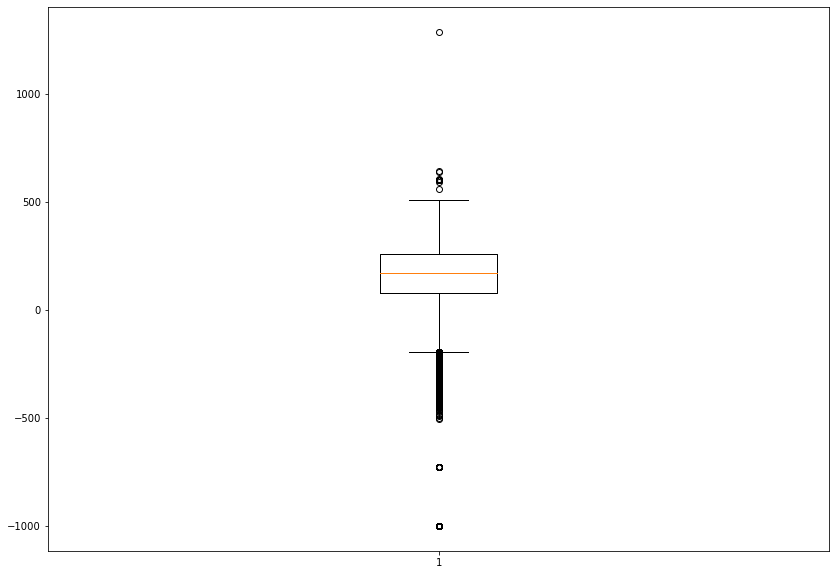

In [12]:
plt.boxplot(data_2015[data_2015.type=='TMAX'].value)
plt.show()

Both the heigh and low outliers go unrealistically far out (units are [tenths of degrees centigrade](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)). Let's keep them for now, though.

Next, we will calculate the difference between the measurement at the station and the measurement and the nearest neighbor, as well as the difference in latitude and population density:

In [13]:
data_2015['nn_value_diff'] = data_2015['value'] - data_2015['value_y']
data_2015.head()

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,NN_popdens1990_diff,NN_popdens1975_diff,nn_elev_diff,nn_lat_diff,climatezone,geometry,Region_Name,station_y,value_y,nn_value_diff
0,USS0018D08S,2015-01-01,TMAX,-8,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0,0.0,-106.7,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,0,-8
1,USS0018D08S,2015-01-01,TMIN,-130,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0,0.0,-106.7,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,-117,-13
2,USS0018D08S,2015-01-02,TMAX,8,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0,0.0,-106.7,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,56,-48
3,USS0018D08S,2015-01-02,TMIN,-77,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0,0.0,-106.7,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,-50,-27
4,USS0018D08S,2015-01-03,TMAX,5,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0,0.0,-106.7,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,11,-6


Before we look at elevation, quick sanity check: Plot temperature against latitude:

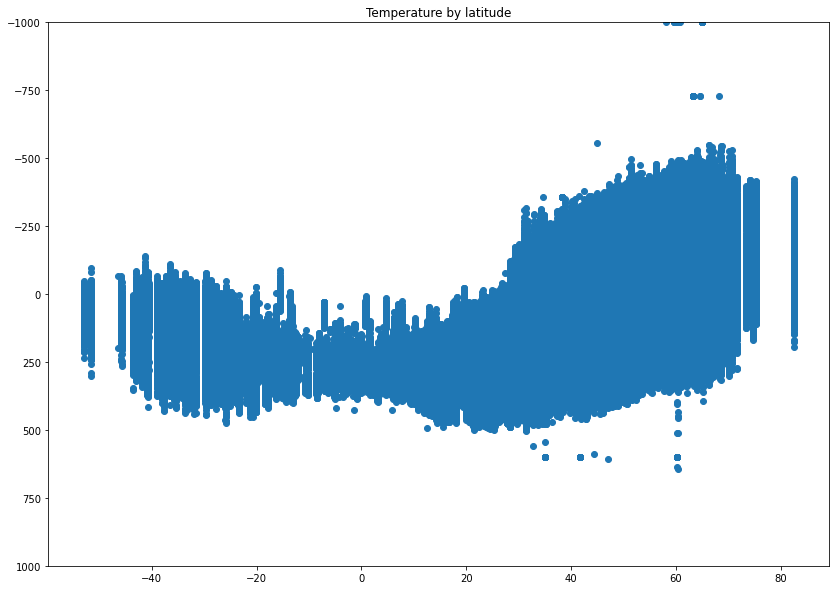

In [17]:
plt.scatter(data_2015['lat'], data_2015['value'])
plt.title('Temperature by latitude')
plt.ylim([1000,-1000])
plt.show()


That's much more messy than I thought. Let's group them by distance from the equator (abs. lat) and make a grouped box plot (for 5 degree latitude intervals). This is probably not the most elegant way to do the grouping, but it works ¯\\\_(ツ)_/¯ 

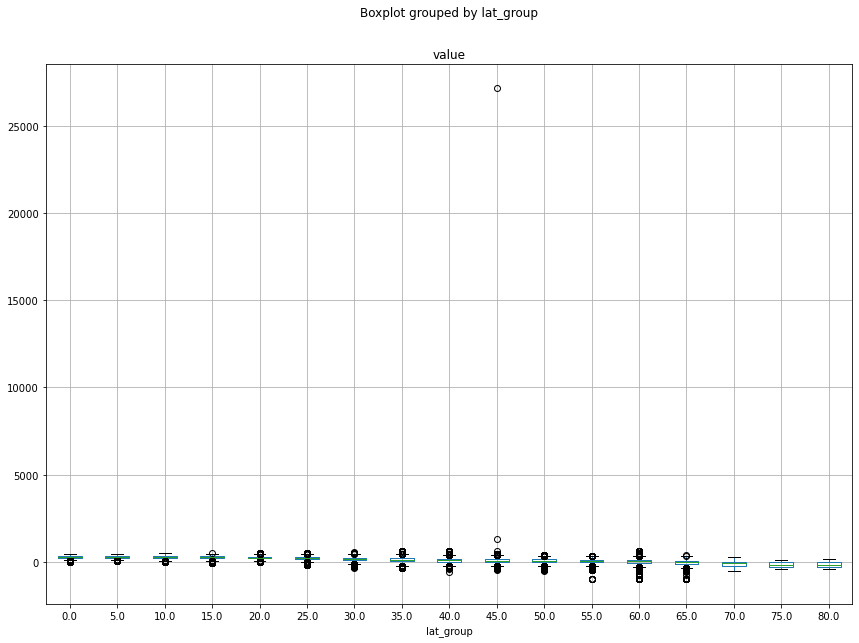

In [18]:
data_2015['lat_group'] = (abs(data_2015.lat) // 5) * 5 # put in 5 degree lat. groups

data_2015.boxplot(column = 'value', by= 'lat_group')

Let's try the same for altitude. Also, we need to take into account how far from the eqator a station is. So we'll 'double-group' them by latitude group **and** altitude group, then we should see a clear trend _within_ each group:

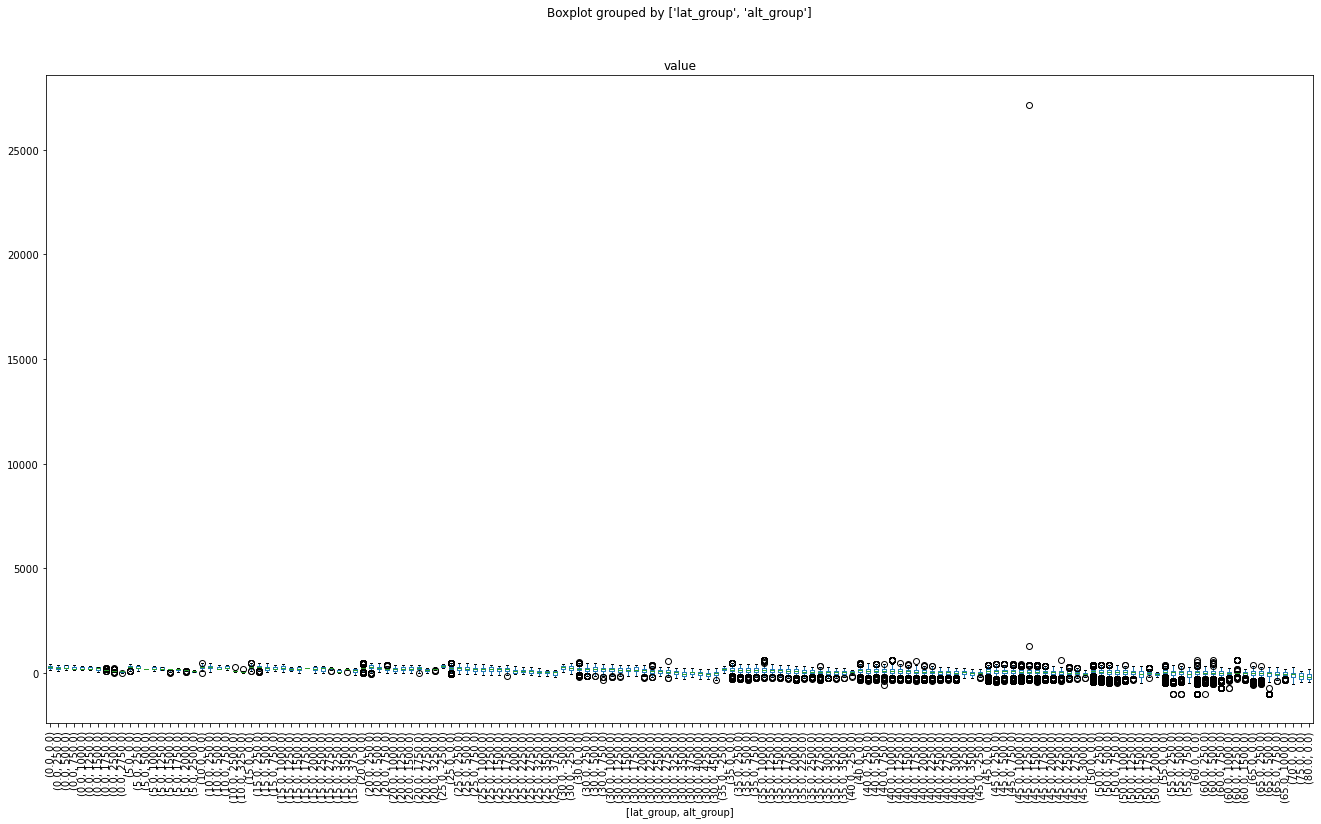

In [19]:
# put in 250m groups
data_2015['alt_group'] = (data_2015.elevation // 250) * 250

data_2015.boxplot(column  = 'value', 
                  by      = ['lat_group', 'alt_group'], 
                  grid    = False, 
                  figsize = (22.0, 12.0), 
                  rot     = 90)

Okay, so now we can plot the difference in temperature against the difference in elevation. We'll check whether the data is reasonably in line with the theoretical [dry adiabatic lapse rate](https://en.wikipedia.org/wiki/Lapse_rate#Dry_adiabatic_lapse_rate) of **9.8°C per km** altitude for each of the latitude groups:

In [20]:
# calculate regression line:
for group in sorted(data_2015.lat_group.unique()):
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_2015[data_2015.lat_group == group].elevation,data_2015[data_2015.lat_group == group].value)
    # units of the output are in 10th of a degree per meter; multiply by 100 to get degrees per kilometer
    print(group,slope*100)

0.0 -6.350713345191998
5.0 -6.637900666144445
10.0 -6.152513287470427
15.0 -4.462567370057306
20.0 -2.659533946112922
25.0 -4.855171075201175
30.0 -4.25599412079021
35.0 -3.8865792798526755
40.0 -3.061441679315433
45.0 -2.180234109156732
50.0 -5.995098948662127
55.0 -11.119885887437409
60.0 -4.082987528984857
65.0 -4.468587743689301
70.0 -62.70757510697028
75.0 nan
80.0 nan


/Users/carsten/miniconda3/envs/UHI-NOAA/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/carsten/miniconda3/envs/UHI-NOAA/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Most of these look like they are more in the range of the [_moist_ adiabatic lapse rate](https://en.wikipedia.org/wiki/Lapse_rate#Moist_adiabatic_lapse_rate), which varies according to temperature, but is generally somewhere around 5°C per km. From about 60°, the lapse rates are closer to the dry adiabatic lapse rate, which makes sense (frost!), but beyond that, they are out of control. No idea what is going on there.

Anyway, this whole grouping exercise doesn't seem to get us anywhere (besides showing that the data generally makes sense, bare the occasional outlier, and is in line with the theory). Let's try a multivariate regression. We'll calculate the difference in latitude and elevation between each station and it's neighbor, as well as the distance between them. Then we will check how much of the difference in temperature for a given day this model can explain, and see if we can find a correlation between the residual and population density at the station.

Note that by using the difference between nearest neighbor stations, we can exclude the date from the model, since we compute these differences on the same day.

First, deal with the minimum daily temperatures (TMIN):

In [21]:
# independent variables:
X = data_2015[data_2015.type == 'TMIN'][['NN_dist','nn_elev_diff','nn_lat_diff']]

# dependent variable
Y = data_2015[data_2015.type == 'TMIN']['nn_value_diff']

regr_TMIN = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMIN.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Let's see how well that works by computing an [R<sup>2</sup> score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) for all observations:

In [22]:
regr_TMIN.score(X,Y)

0.052699092185495844

That's quite low. Let's try to include time in the equation (UHI only occurs in the summer, so including time should yield a better fit). First, let's try it with the day of the year. 

🔥 TODO: Also check the rest of the code for possible uses of apply/lambda instead of looping through the data frame.

In [23]:
data_2015['yday'] = data_2015['date'].apply(lambda x: x.timetuple().tm_yday)
data_2015.head(15)

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,nn_lat_diff,climatezone,geometry,Region_Name,station_y,value_y,nn_value_diff,lat_group,alt_group,yday
0,USS0018D08S,2015-01-01,TMAX,-8,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,0,-8,45.0,1250.0,1
1,USS0018D08S,2015-01-01,TMIN,-130,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,-117,-13,45.0,1250.0,1
2,USS0018D08S,2015-01-02,TMAX,8,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,56,-48,45.0,1250.0,2
3,USS0018D08S,2015-01-02,TMIN,-77,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,-50,-27,45.0,1250.0,2
4,USS0018D08S,2015-01-03,TMAX,5,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,11,-6,45.0,1250.0,3
5,USS0018D08S,2015-01-03,TMIN,-26,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,-39,13,45.0,1250.0,3
6,USS0018D08S,2015-01-04,TMAX,36,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,17,19,45.0,1250.0,4
7,USS0018D08S,2015-01-04,TMIN,-20,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,-17,-3,45.0,1250.0,4
8,USS0018D08S,2015-01-05,TMAX,75,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,67,8,45.0,1250.0,5
9,USS0018D08S,2015-01-05,TMIN,28,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,0.0761,13,POINT (-118.55 45.19),North America,USR0000OJRI,11,17,45.0,1250.0,5


In [24]:
data_2015.iloc[300]

station                          USS0018D08S
date                     2015-05-31 00:00:00
type                                    TMAX
value                                    234
lat                                    45.19
lon                                  -118.55
elevation                             1472.2
name                             County Line
country                                   US
mollX                           -9.55532e+06
mollY                            5.36084e+06
pop2015                                    0
pop2000                                    0
pop1990                                    0
pop1975                                    0
popdens2015                                0
popdens2000                                0
popdens1990                                0
popdens1975                                0
NN                               USR0000OJRI
NN_dist                              9067.11
NN_elev                               1578.9
NN_lat    

Build another regression model, but with day of the year as additional independent variable:

In [25]:
# independent variables:
X = data_2015[data_2015.type == 'TMIN'][['NN_dist','nn_elev_diff','nn_lat_diff','yday']]

# dependent variable
Y = data_2015[data_2015.type == 'TMIN']['nn_value_diff']

regr_TMIN_time = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMIN_time.fit(X, Y)
regr_TMIN_time.score(X, Y)

0.05270151517326371

Okay, (almost) no difference at all. This is a bit weird. Anyway, let's take a look at the residuals and plot them against difference in population density. We need to calculate the residuals first:

In [26]:
data_2015['predicted_diff'] = regr_TMIN_time.predict(data_2015[['NN_dist','nn_elev_diff','nn_lat_diff','yday']])
data_2015[data_2015.type == 'TMIN'].head()

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,climatezone,geometry,Region_Name,station_y,value_y,nn_value_diff,lat_group,alt_group,yday,predicted_diff
1,USS0018D08S,2015-01-01,TMIN,-130,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,13,POINT (-118.55 45.19),North America,USR0000OJRI,-117,-13,45.0,1250.0,1,3.104688
3,USS0018D08S,2015-01-02,TMIN,-77,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,13,POINT (-118.55 45.19),North America,USR0000OJRI,-50,-27,45.0,1250.0,2,3.104011
5,USS0018D08S,2015-01-03,TMIN,-26,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,13,POINT (-118.55 45.19),North America,USR0000OJRI,-39,13,45.0,1250.0,3,3.103334
7,USS0018D08S,2015-01-04,TMIN,-20,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,13,POINT (-118.55 45.19),North America,USR0000OJRI,-17,-3,45.0,1250.0,4,3.102657
9,USS0018D08S,2015-01-05,TMIN,28,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,13,POINT (-118.55 45.19),North America,USR0000OJRI,11,17,45.0,1250.0,5,3.101980


In [27]:
data_2015['residual'] = data_2015['nn_value_diff'] - data_2015['predicted_diff']
data_2015.head()

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,geometry,Region_Name,station_y,value_y,nn_value_diff,lat_group,alt_group,yday,predicted_diff,residual
0,USS0018D08S,2015-01-01,TMAX,-8,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,POINT (-118.55 45.19),North America,USR0000OJRI,0,-8,45.0,1250.0,1,3.104688,-11.104688
1,USS0018D08S,2015-01-01,TMIN,-130,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,POINT (-118.55 45.19),North America,USR0000OJRI,-117,-13,45.0,1250.0,1,3.104688,-16.104688
2,USS0018D08S,2015-01-02,TMAX,8,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,POINT (-118.55 45.19),North America,USR0000OJRI,56,-48,45.0,1250.0,2,3.104011,-51.104011
3,USS0018D08S,2015-01-02,TMIN,-77,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,POINT (-118.55 45.19),North America,USR0000OJRI,-50,-27,45.0,1250.0,2,3.104011,-30.104011
4,USS0018D08S,2015-01-03,TMAX,5,45.19,-118.55,1472.2,County Line,US,-9.555320e+06,...,POINT (-118.55 45.19),North America,USR0000OJRI,11,-6,45.0,1250.0,3,3.103334,-9.103334


Save a snapshot of the data:

In [29]:
file = 'data_2015_complete.csv'

if not (os.path.isfile(file)):
    data_2015.to_csv(file)
else:
    print("File already saved.")

🏁

In [30]:
data_2015 = pd.read_csv('data_2015_complete.csv', index_col=0)

/Users/carsten/miniconda3/envs/UHI-NOAA/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


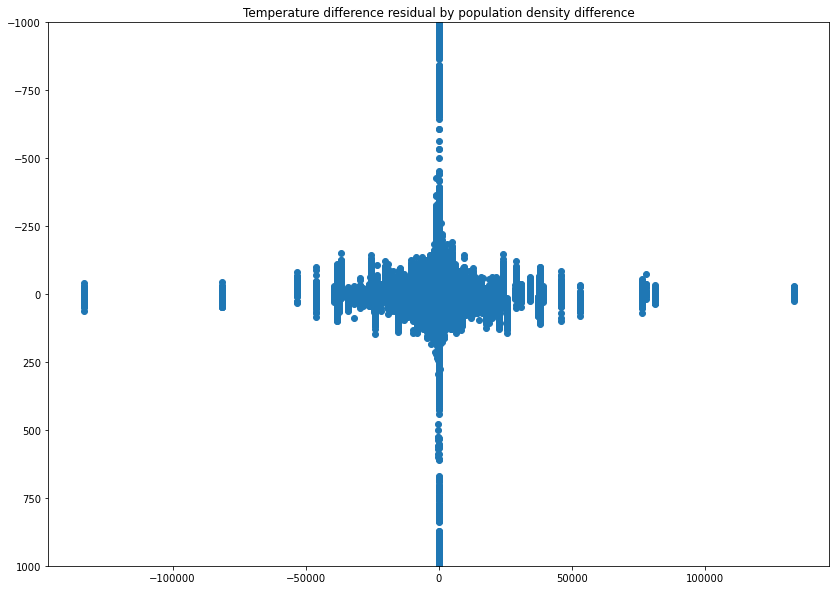

In [32]:
plt.scatter(data_2015[data_2015.type == 'TMIN']['NN_popdens2015_diff'], 
            data_2015[data_2015.type == 'TMIN']['residual'])
plt.title('Temperature difference residual by population density difference')
plt.ylim([1000,-1000])
plt.show()

Hm, no clear trend to see here ☹️

There are two issues here: 

1. Each pair of nearest neighbor stations appears twice, once with A as nearest neighbor of B, and once with B as nearst neighbor of A – and this applies to all 365 measurements made in 2015. This basically means we can get rid of the whole negative section of the scatter plot above on both axes.
2. We are really only interested in the trend for the stations where there is a population difference. So we'll do this again, but only for the stations where there is a difference in population density of at least 100 people per km<sup>2</sup>:

Text(0.5, 1.0, 'Daily MINIMUM temperature residual by population density difference (log/log scale)')

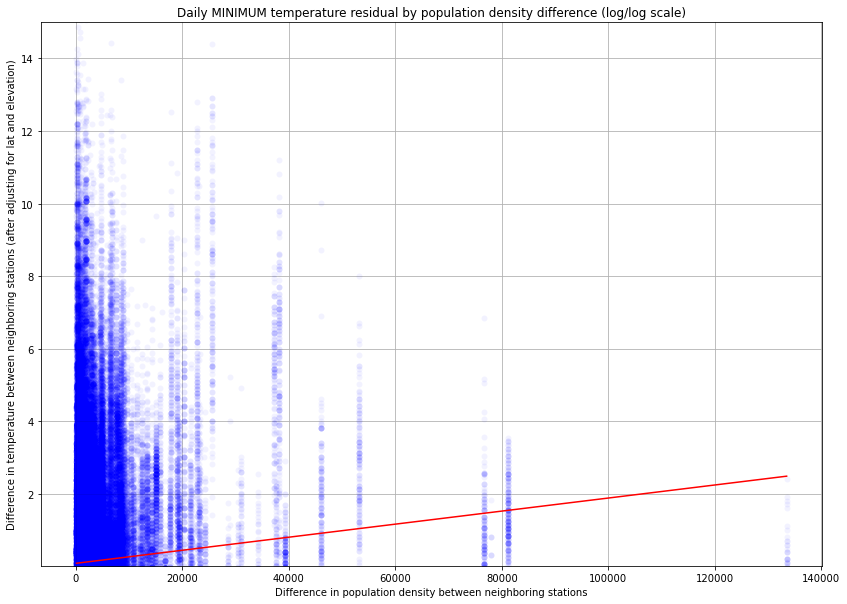

In [33]:
tmin = (data_2015.type == 'TMIN')
morethan100 = (data_2015.NN_popdens2015_diff >= 100)

x = data_2015[tmin & morethan100]['NN_popdens2015_diff']
y = (data_2015[tmin & morethan100]['residual']) / 10

fig = plt.figure()
ax = plt.gca()
# scatter
ax.plot(x, y, 'o', c='blue', alpha=0.05, markeredgecolor='none')
# plynomial fit line
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c='red')
    
#ax.set_xscale('log')
#ax.set_yscale('log')

# axis labels
plt.xlabel("Difference in population density between neighboring stations")
plt.ylabel("Difference in temperature between neighboring stations (after adjusting for lat and elevation)")

# don't show the outliers in the scatter (buyt they are still used to fit the line!)
ax.set_ylim([0.01,15])

plt.grid(True)
plt.title('Daily MINIMUM temperature residual by population density difference')

Let's do the same for max:

Text(0.5, 1.0, 'Daily MAXIMUM temperature residual by population density difference (log/log scale)')

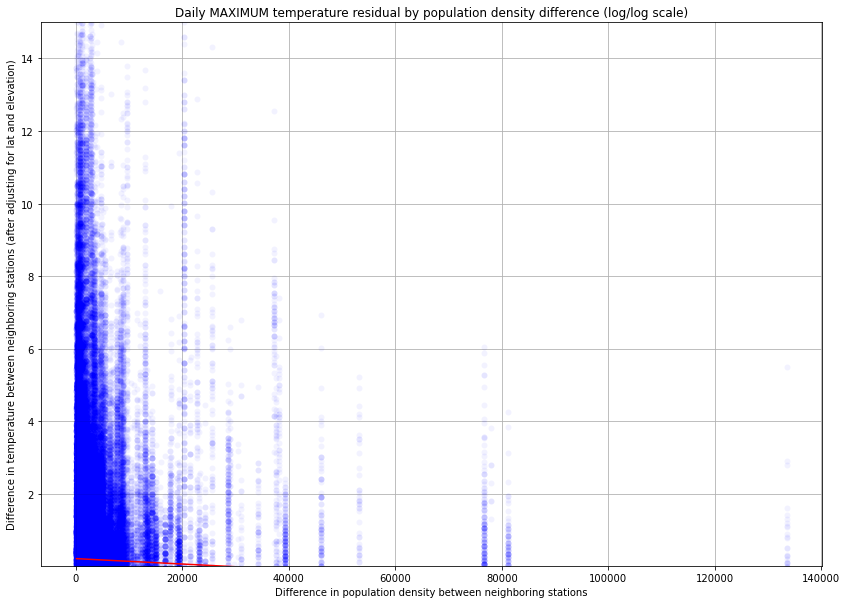

In [34]:
tmax = (data_2015.type == 'TMAX')
morethan100 = (data_2015.NN_popdens2015_diff >= 100)

x = data_2015[tmax & morethan100]['NN_popdens2015_diff']
y = (data_2015[tmax & morethan100]['residual']) / 10

fig = plt.figure()
ax = plt.gca()
# scatter
ax.plot(x, y, 'o', c='blue', alpha=0.05, markeredgecolor='none')
# plynomial fit line
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c='red')
    
#ax.set_xscale('log')
#ax.set_yscale('log')

# axis labels
plt.xlabel("Difference in population density between neighboring stations")
plt.ylabel("Difference in temperature between neighboring stations (after adjusting for lat and elevation)")

# don't show the outliers in the scatter (buyt they are still used to fit the line!)
ax.set_ylim([0.01,15])

plt.grid(True)
plt.title('Daily MAXIMUM temperature residual by population density difference')

Rebeca trying stuff from here

Add a max distance limit

Text(0.5, 1.0, 'Daily MAXIMUM temperature residual by population density difference (log/log scale)')

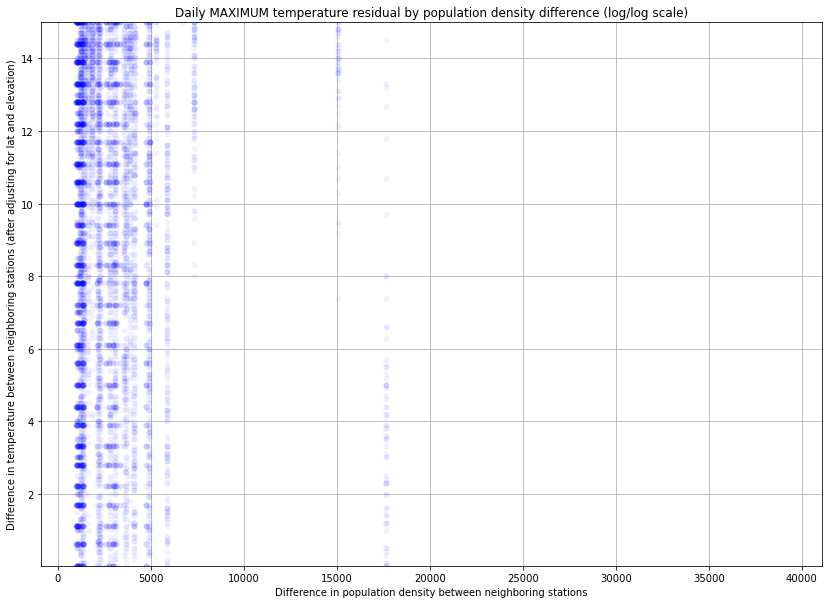

In [35]:
tmax = (data_2015.type == 'TMAX')
morethan100 = (data_2015.NN_popdens2015_diff >= 1000)
dist = (data_2015.NN_dist <= 10000)

x = data_2015[tmax & morethan100 & dist]['NN_popdens2015_diff']
y = (data_2015[tmax & morethan100 & dist]['value']) / 10

fig = plt.figure()
ax = plt.gca()
# scatter
ax.plot(x, y, 'o', c='blue', alpha=0.05, markeredgecolor='none')
# plynomial fit line
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c='red')
    
#ax.set_xscale('log')
#ax.set_yscale('log')

# axis labels
plt.xlabel("Difference in population density between neighboring stations")
plt.ylabel("Difference in temperature between neighboring stations (after adjusting for lat and elevation)")

# don't show the outliers in the scatter (buyt they are still used to fit the line!)
ax.set_ylim([0.01,15])

plt.grid(True)
plt.title('Daily MAXIMUM temperature residual by population density difference')

Try adding a limit to the temperature(to make sure that we exclude the really high values that made no sense) and distance between NN under 10km


Text(0.5, 1.0, 'Daily MAXIMUM temperature residual by population density difference (log/log scale)')

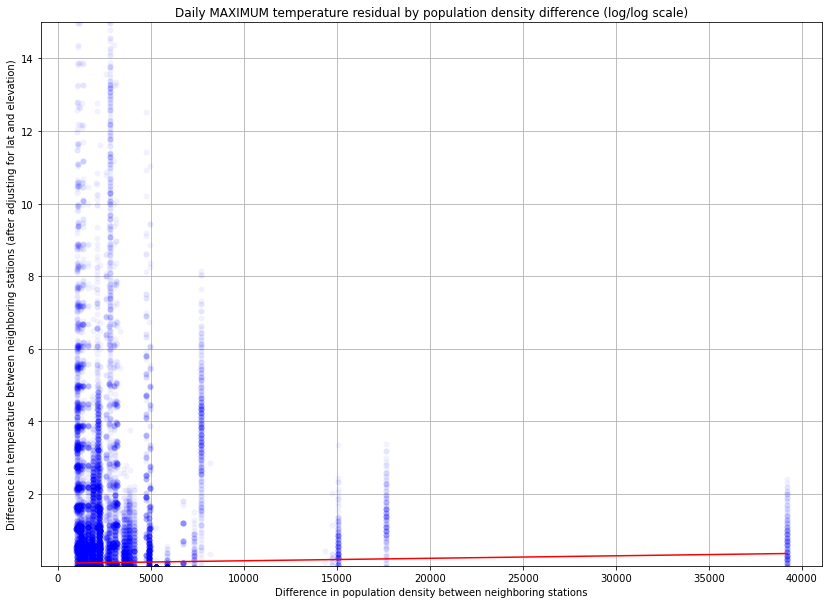

In [36]:
tmax = (data_2015.type == 'TMAX')
morethan100 = (data_2015.NN_popdens2015_diff >= 1000)
dist = (data_2015.NN_dist <= 10000)
temp = (data_2015.value <= 560)

x = data_2015[tmax & morethan100 & dist & temp]['NN_popdens2015_diff']
y = (data_2015[tmax & morethan100 & dist & temp]['residual']) / 10

fig = plt.figure()
ax = plt.gca()
# scatter
ax.plot(x, y, 'o', c='blue', alpha=0.05, markeredgecolor='none')
# plynomial fit line
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c='red')
    
#ax.set_xscale('log')
#ax.set_yscale('log')

# axis labels
plt.xlabel("Difference in population density between neighboring stations")
plt.ylabel("Difference in temperature between neighboring stations (after adjusting for lat and elevation)")

# don't show the outliers in the scatter (buyt they are still used to fit the line!)
ax.set_ylim([0.01,15])

plt.grid(True)
plt.title('Daily MAXIMUM temperature residual by population density difference')

Now only for summer (approx, not exact dates)

Text(0.5, 1.0, 'Daily MAXIMUM temperature residual by population density difference (log/log scale)')

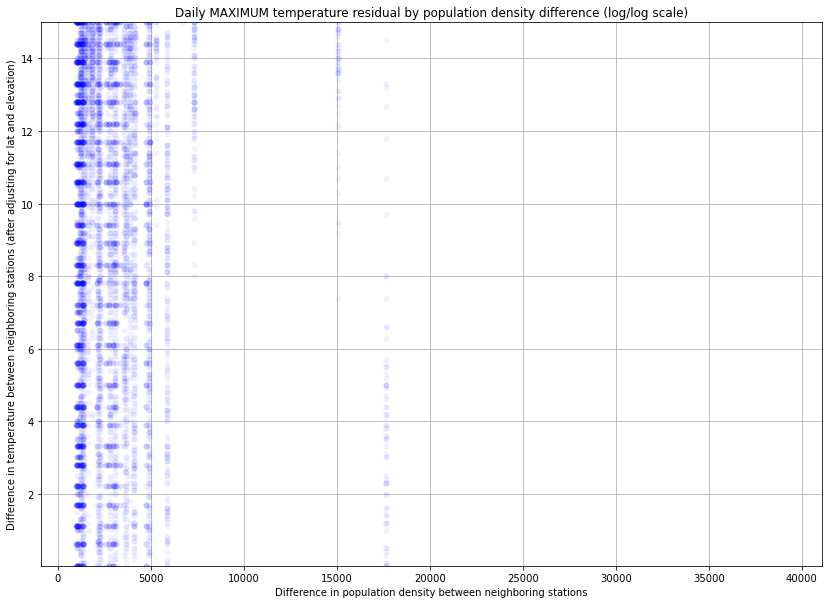

In [37]:
tmax = (data_2015.type == 'TMAX')
morethan100 = (data_2015.NN_popdens2015_diff >= 1000)
dist = (data_2015.NN_dist <= 10000)
temp = (data_2015.value <= 500)
summer = (data_2015.yday >=160)
wint = (data_2015.yday <= 260)

x = data_2015[tmax & morethan100 & dist & temp]['NN_popdens2015_diff']
y = (data_2015[tmax & morethan100 & dist & temp]['value']) / 10

fig = plt.figure()
ax = plt.gca()
# scatter
ax.plot(x, y, 'o', c='blue', alpha=0.05, markeredgecolor='none')
# plynomial fit line
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c='red')
    
#ax.set_xscale('log')
#ax.set_yscale('log')

# axis labels
plt.xlabel("Difference in population density between neighboring stations")
plt.ylabel("Difference in temperature between neighboring stations (after adjusting for lat and elevation)")

# don't show the outliers in the scatter (buyt they are still used to fit the line!)
ax.set_ylim([0.01,15])

plt.grid(True)
plt.title('Daily MAXIMUM temperature residual by population density difference (log/log scale)')

Exclude high temperatures, popdens differences, distance, season and then try linear regression again (https://public.wmo.int/en/media/press-release/wmo-verifies-3rd-and-4th-hottest-temperature-recorded-earth) (https://wmo.asu.edu/content/northern-hemisphere-lowest-temperature)

In [38]:
temperatures = data_2015[(data_2015.value <= 570) & (data_2015.value>=-650)] # exclude extreme temperatures

popdens_temp = temperatures[temperatures.NN_popdens2015_diff >= 1000] # pick neighbouring stations with difference in pop.dens

north = popdens_temp[popdens_temp.lat>0] # exclude stations in southern hemisphere

tropic = north[north.lat<=23.5] # pick stations in the tropic only

temperate = north[(north.lat>23.5) & (north.lat<=60)] # pick only stations in the temperate region of the northern hemisphere

summer = north[(north.yday>=151) & (north.yday<=243)] #summer only, whole hemisphere

tropic_summer = summer[summer.lat<=23.5] # tropic summer only

temperate_summer = summer[(summer.lat>23.5) & (summer.lat<=60)] #temperate summer only


In [39]:
tropic

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,geometry,Region_Name,station_y,value_y,nn_value_diff,lat_group,alt_group,yday,predicted_diff,residual
25473,TH000048327,2015-01-01,TMAX,290,18.783,98.983,313.0,CHIANG MAI,TH,9.590557e+06,...,POINT (98.983 18.783),Asia,TH000048328,290,0,15.0,250.0,1,-4.274707,4.274707
25474,TH000048327,2015-01-02,TMAX,285,18.783,98.983,313.0,CHIANG MAI,TH,9.590557e+06,...,POINT (98.983 18.783),Asia,TH000048328,295,-10,15.0,250.0,2,-4.275384,-5.724616
25475,TH000048327,2015-01-03,TMAX,293,18.783,98.983,313.0,CHIANG MAI,TH,9.590557e+06,...,POINT (98.983 18.783),Asia,TH000048328,300,-7,15.0,250.0,3,-4.276061,-2.723939
25476,TH000048327,2015-01-04,TMAX,307,18.783,98.983,313.0,CHIANG MAI,TH,9.590557e+06,...,POINT (98.983 18.783),Asia,TH000048328,324,-17,15.0,250.0,4,-4.276738,-12.723262
25477,TH000048327,2015-01-05,TMAX,315,18.783,98.983,313.0,CHIANG MAI,TH,9.590557e+06,...,POINT (98.983 18.783),Asia,TH000048328,331,-16,15.0,250.0,5,-4.277415,-11.722585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012413,SUM00062733,2015-01-23,TMAX,362,15.317,35.600,451.0,HALFA EL GAIDIDA,SU,3.489133e+06,...,POINT (35.6 15.317),Africa,SU000062730,370,-8,15.0,250.0,23,2.420110,-10.420110
2012414,SUM00062733,2015-01-23,TMIN,170,15.317,35.600,451.0,HALFA EL GAIDIDA,SU,3.489133e+06,...,POINT (35.6 15.317),Africa,SU000062730,195,-25,15.0,250.0,23,2.420110,-27.420110
2012415,SUM00062772,2015-01-23,TMAX,346,13.167,32.667,381.0,KOSTI/RABAK,SU,3.220573e+06,...,POINT (32.667 13.167),Africa,SU000062762,362,-16,10.0,250.0,23,3.184485,-19.184485
2012418,SUM00062772,2015-02-12,TMIN,180,13.167,32.667,381.0,KOSTI/RABAK,SU,3.220573e+06,...,POINT (32.667 13.167),Africa,SU000062762,140,40,10.0,250.0,43,3.170947,36.829053


linear regression for whole world, whole year

In [40]:
# independent variables:
X = popdens_temp[popdens_temp.type == 'TMIN'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = popdens_temp[popdens_temp.type == 'TMIN']['nn_value_diff']

regr_TMIN = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMIN.fit(X, Y)

regr_TMIN.score(X,Y)

0.39800703154141476

In [41]:
# independent variables:
X = popdens_temp[popdens_temp.type == 'TMAX'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = popdens_temp[popdens_temp.type == 'TMAX']['nn_value_diff']

regr_TMAX = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMAX.fit(X, Y)

regr_TMAX.score(X,Y)

0.36904871450012505

With time

In [39]:
# independent variables:
X = popdens_temp[popdens_temp.type == 'TMIN'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff','yday']]

# dependent variable
Y = popdens_temp[popdens_temp.type == 'TMIN']['nn_value_diff']

regr_TMIN = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMIN.fit(X, Y)

regr_TMIN.score(X,Y)

0.39808270594066847

Northern hemisphere, whole year

In [40]:
# independent variables:
X = north[north.type == 'TMIN'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = north[north.type == 'TMIN']['nn_value_diff']

regr_TMIN = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMIN.fit(X, Y)

regr_TMIN.score(X,Y)

0.38076359091823875

In [41]:
# independent variables:
X = north[north.type == 'TMAX'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = north[north.type == 'TMAX']['nn_value_diff']

regr_TMAX = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMAX.fit(X, Y)

regr_TMAX.score(X,Y)

0.42378092120171196

Tropic: norhtern hemisphere, tropic, whole year

In [42]:
# independent variables:
X = tropic[tropic.type == 'TMIN'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = tropic[tropic.type == 'TMIN']['nn_value_diff']

regr_TMIN = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMIN.fit(X, Y)

regr_TMIN.score(X,Y)

0.6866737030580462

In [43]:
# independent variables:
X = tropic[tropic.type == 'TMAX'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = tropic[tropic.type == 'TMAX']['nn_value_diff']

regr_TMAX = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMAX.fit(X, Y)

regr_TMAX.score(X,Y)

0.5369807535354858

Temperate: norhtern hemisphere, temperate region, whole year

In [44]:
# independent variables:
X = temperate[temperate.type == 'TMIN'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = temperate[temperate.type == 'TMIN']['nn_value_diff']

regr_TMIN = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMIN.fit(X, Y)

regr_TMIN.score(X,Y)

0.3413399208631228

In [45]:
# independent variables:
X = temperate[temperate.type == 'TMAX'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = temperate[temperate.type == 'TMAX']['nn_value_diff']

regr_TMAX = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMAX.fit(X, Y)

regr_TMAX.score(X,Y)

0.4203994721220489

Summer: Northern hemisphere, summer only

In [46]:
# independent variables:
X = summer[summer.type == 'TMIN'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = summer[summer.type == 'TMIN']['nn_value_diff']

regr_TMIN = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMIN.fit(X, Y)

regr_TMIN.score(X,Y)

0.46205886761592146

In [47]:
X = summer[summer.type == 'TMAX'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = summer[summer.type == 'TMAX']['nn_value_diff']

regr_TMAX = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMAX.fit(X, Y)

regr_TMAX.score(X,Y)

0.4431872638584271

Tropic summer: norhtern hemisphere, tropic, summer

In [43]:
# independent variables:
X = tropic_summer[tropic_summer.type == 'TMIN'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = tropic_summer[tropic_summer.type == 'TMIN']['nn_value_diff']

regr_TMIN = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMIN.fit(X, Y)

print(regr_TMIN.score(X,Y))
print(regr_TMIN.coef_)

0.7809614415331617
[-6.19476891e-02  3.91167793e+00  8.06994687e-05]


In [44]:
X = tropic_summer[tropic_summer.type == 'TMAX'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = tropic_summer[tropic_summer.type == 'TMAX']['nn_value_diff']

regr_TMAX = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMAX.fit(X, Y)

print(regr_TMAX.score(X,Y))
print(regr_TMIN.coef_)

0.5114609489163291
[-6.19476891e-02  3.91167793e+00  8.06994687e-05]


Temperate summer: norhtern hemisphere, temperate region, summer

In [50]:
# independent variables:
X = temperate_summer[temperate_summer.type == 'TMIN'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = temperate_summer[temperate_summer.type == 'TMIN']['nn_value_diff']

regr_TMIN = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMIN.fit(X, Y)

regr_TMIN.score(X,Y)

0.41521793055529

In [51]:
X = temperate_summer[temperate_summer.type == 'TMAX'][['nn_elev_diff','nn_lat_diff','NN_popdens2015_diff']]

# dependent variable
Y = temperate_summer[temperate_summer.type == 'TMAX']['nn_value_diff']

regr_TMAX = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMAX.fit(X, Y)

regr_TMAX.score(X,Y)

0.4527661778636724

SOUTH HEMISPHERE

In [42]:
southsummer = popdens_temp[(popdens_temp.yday<=58) & (popdens_temp.yday>333)]

south= southsummer[southsummer.lat<0]

south

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,geometry,Region_Name,station_y,value_y,nn_value_diff,lat_group,alt_group,yday,predicted_diff,residual


Text(0.5, 1.0, 'Daily MAXIMUM temperature residual by population density difference (log/log scale)')

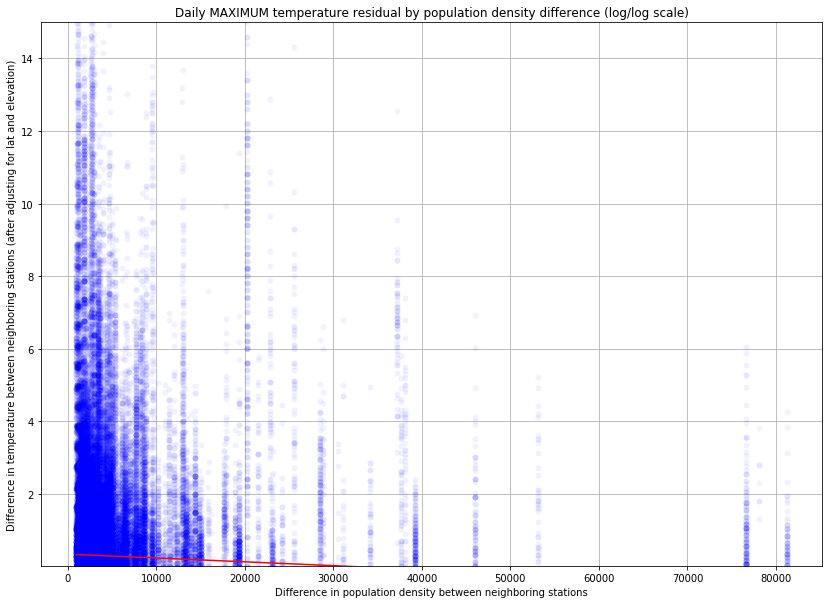

In [252]:
tmax = (north.type == 'TMAX')
morethan100 = (north.NN_popdens2015_diff >= 1000)
dist = (north.NN_dist <= 10000)


x = north[tmax & morethan100]['NN_popdens2015_diff']
y = (north[tmax & morethan100]['residual']) / 10

fig = plt.figure()
ax = plt.gca()
# scatter
ax.plot(x, y, 'o', c='blue', alpha=0.05, markeredgecolor='none')
# plynomial fit line
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c='red')
    
#ax.set_xscale('log')
#ax.set_yscale('log')

# axis labels
plt.xlabel("Difference in population density between neighboring stations")
plt.ylabel("Difference in temperature between neighboring stations (after adjusting for lat and elevation)")

# don't show the outliers in the scatter (buyt they are still used to fit the line!)
ax.set_ylim([0.01,15])

plt.grid(True)
plt.title('Daily MAXIMUM temperature residual by population density difference (log/log scale)')